<a href="https://colab.research.google.com/github/samarthbiraje26/Google-Solutions-Challenge-2025/blob/main/UntrainedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install numpy pandas matplotlib scikit-learn tensorflow yfinance forex-python



In [32]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from forex_python.converter import CurrencyRates
import requests

In [70]:
# Get stock data for the last 6 months with proper validation for data availability
symbol = input("Enter the stock symbol (e.g., AAPL, TSLA, MSFT): ")
ticker = yf.Ticker(symbol)
data = ticker.history(period="6mo", interval="1d")

if data.empty:
    print("No data available. Please check the symbol or try again.")
else:
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    print("Data Fetched Successfully")

    # Convert from Paise to INR if it is an Indian stock (NSE or BSE)
    if symbol.endswith(".NS") or symbol.endswith(".BO"):
        print("Detected Indian stock. Converting from Paise to INR.")
        data[['Open', 'High', 'Low', 'Close']] /= 100

    # Convert USD to INR using a currency exchange API
    try:
        response = requests.get('https://api.exchangerate-api.com/v4/latest/USD')
        response.raise_for_status()
        exchange_rate = response.json()['rates']['INR']
        print(f"Current USD to INR Conversion Rate: {exchange_rate}")

        data[['Open', 'High', 'Low', 'Close']] *= exchange_rate
        print(data)
    except Exception as e:
        print(f"Error fetching exchange rate: {e}")


Enter the stock symbol (e.g., AAPL, TSLA, MSFT): IRCTC.NS
Data Fetched Successfully
Detected Indian stock. Converting from Paise to INR.
Current USD to INR Conversion Rate: 85.66
                                 Open        High         Low       Close  \
Date                                                                        
2024-09-25 00:00:00+05:30  775.815633  775.815633  761.385802  764.993259   
2024-09-26 00:00:00+05:30  763.932196  771.571518  758.754454  769.661688   
2024-09-27 00:00:00+05:30  765.672309  787.699032  765.672309  785.067731   
2024-09-30 00:00:00+05:30  780.908553  791.688497  780.908553  788.165900   
2024-10-01 00:00:00+05:30  785.152581  792.791903  781.120716  790.372805   
...                               ...         ...         ...         ...   
2025-03-19 00:00:00+05:30  609.042600  619.321800  605.958861  614.739011   
2025-03-20 00:00:00+05:30  619.493130  621.805961  610.027711  612.340489   
2025-03-21 00:00:00+05:30  613.925230  621.634630  

In [62]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert data into sequences
sequence_length = 60

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length - 30):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length:i+sequence_length+30])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, sequence_length)
print(f"Training Data Shape: {X.shape}, Labels Shape: {y.shape}")

Training Data Shape: (35, 60, 5), Labels Shape: (35, 30, 5)


In [66]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, len(data.columns))))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(30 * len(data.columns)))
model.compile(optimizer='adam', loss='mean_squared_error')

print("Model Built Successfully")

Model Built Successfully


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [67]:
history = model.fit(X, y.reshape(y.shape[0], -1), epochs=50, batch_size=64, validation_split=0.2)
model.save('lstm_30day_stock_prediction.h5')
print("Model Training Complete and Saved")

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0711 - val_loss: 0.0524
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0675 - val_loss: 0.0494
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0643 - val_loss: 0.0461
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0606 - val_loss: 0.0421
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0562 - val_loss: 0.0371
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0509 - val_loss: 0.0317
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0446 - val_loss: 0.0278
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.0405 - val_loss: 0.0244
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0362 - val_loss: 0.0207
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0313 - val_loss: 0.0183
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0269 - val_loss: 0.0168
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0251 - val_loss: 0.0156
Ep

Model Training Complete and Saved


In [68]:
# Use the latest data to predict
last_sequence = scaled_data[-sequence_length:]
pred_input = np.array([last_sequence])

# Predict for the next 30 days
model = load_model('lstm_30day_stock_prediction.h5')
predictions = model.predict(pred_input)
predictions_actual = scaler.inverse_transform(predictions.reshape(30, len(data.columns)))

print("30-Day Prediction Complete")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
30-Day Prediction Complete


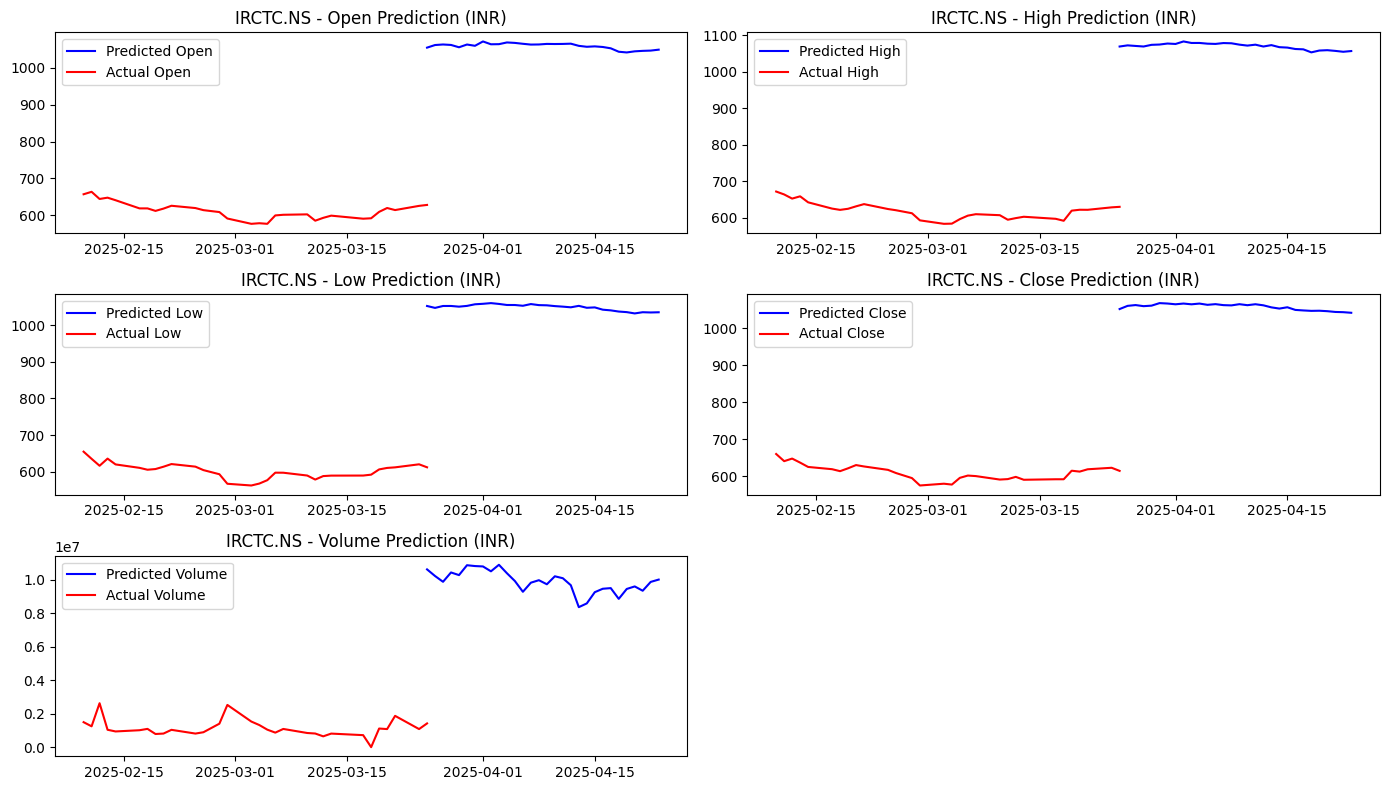

Displaying data in tabular format using Pandas DataFrame:
                                 Open        High         Low       Close  \
Date                                                                        
2025-02-10 00:00:00+05:30  656.865061  671.665831  654.476471  660.021436   
2025-02-11 00:00:00+05:30  663.519043  663.689668  634.941146  640.614092   
2025-02-12 00:00:00+05:30  644.068991  652.343795  615.960274  647.609258   
2025-02-13 00:00:00+05:30  647.609266  658.571214  635.538283  636.689909   
2025-02-14 00:00:00+05:30  640.656714  642.149589  619.628480  624.960177   
2025-02-17 00:00:00+05:30  618.476878  624.960201  610.244717  618.860771   
2025-02-18 00:00:00+05:30  618.476836  621.462587  605.083603  613.529032   
2025-02-19 00:00:00+05:30  611.652272  624.448345  606.960379  621.291970   
2025-02-20 00:00:00+05:30  617.865570  631.142870  613.325600  630.029300   
2025-02-21 00:00:00+05:30  625.617789  637.224761  620.606700  626.260239   
2025-02-24 00:00:0

In [72]:
plt.figure(figsize=(14,8))
dates = pd.date_range(start=data.index[-1], periods=30)
features = ['Open', 'High', 'Low', 'Close', 'Volume']

for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    plt.plot(dates, predictions_actual[:, i], color='blue', label='Predicted ' + feature)
    plt.plot(data.index[-30:], data[feature].tail(30), color='red', label='Actual ' + feature)
    plt.title(f'{symbol} - {feature} Prediction (INR)')
    plt.legend()

plt.tight_layout()
plt.show()


  # Display data in a tabular format
print("Displaying data in tabular format using Pandas DataFrame:")
print(data.tail(30))
